In [25]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
%matplotlib inline

* pkl 불러오기

In [26]:
df = pd.read_pickle('data/main.pkl')

In [27]:
df.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Breed2,Type,numCol
26724,A702446,Unnamed,2015-05-14 11:56:00,Transfer,Partner,Cat,Male,30,Domestic Shorthair,dark,Mix,Cat,1
26725,A718934,Unnamed,2016-01-20 18:59:00,Transfer,SCRP,Cat,Neutered,90,Domestic Shorthair,dark,Mix,Cat,0
26726,A698128,Named,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered,1460,Old English Bulldog,light,Mix,Cat,1
26727,A677478,Unnamed,2014-04-27 12:22:00,Transfer,Partner,Cat,Male,28,Domestic Shorthair,dark,Mix,Cat,0
26728,A706629,Unnamed,2015-07-02 09:00:00,Transfer,SCRP,Cat,Male,365,Domestic Shorthair,dark,Mix,Cat,1


## 더미화

In [28]:
encoder = LabelEncoder()
df['Name'] = encoder.fit_transform(df['Name'])
df['SexuponOutcome'] = encoder.fit_transform(df['SexuponOutcome'])
df['Type'] = encoder.fit_transform(df['Type'])
df['Breed2'] = encoder.fit_transform(df['Breed2'])
df['Color'] = encoder.fit_transform(df['Color'])
df['Breed'] = encoder.fit_transform(df['Breed'])

In [29]:
df.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Breed2,Type,numCol
26724,A702446,1,2015-05-14 11:56:00,Transfer,Partner,Cat,1,30,81,1,0,0,1
26725,A718934,1,2016-01-20 18:59:00,Transfer,SCRP,Cat,2,90,81,1,0,0,0
26726,A698128,0,2015-03-09 13:33:00,Adoption,NaN,Dog,2,1460,146,2,0,0,1
26727,A677478,1,2014-04-27 12:22:00,Transfer,Partner,Cat,1,28,81,1,0,0,0
26728,A706629,1,2015-07-02 09:00:00,Transfer,SCRP,Cat,1,365,81,1,0,0,1


# 변수선택
* Name, SexuponOutcome, AgeuponOutcome, Breed, Breed2(순종여부), Type(AKC 분류), Color, numCol(색의 혼합도)
* 8개의 변수

In [30]:
X = df[['Name', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Type', 'Breed2', 'Color', 'numCol']]
y = df['OutcomeType']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

# Validation

In [32]:
# Cross Validation
def model_cv(train, test, train_y, test_y, model, name):
    model.fit(train, train_y)
    print(name,': ',model.best_params_)
    pred_y = model.predict_proba(test)
    print('train score: {}'.format(model.score(train, train_y)))
    print('test score: {}'.format(model.score(test, test_y)))
    print('log loss: {}'.format(log_loss(test_y, pred_y)))
    print()


## Random forest
* 우선 Random Forest 를 통하여 Overfitting을 예방하고
* feature importance 기능을 통해 최종변수를 선택하고자 함

In [33]:
def forest(train, test, train_y, test_y):
    param = [{'n_estimators':[100, 300, 500, 1000],
             'criterion': ['gini', 'entropy']
         }]
    model = GridSearchCV(RandomForestClassifier(n_jobs=-1), param, cv=3)
    name = 'Random forest'
    return model_cv(train, test, train_y, test_y, model, name)

In [34]:
forest(X_train, X_test, y_train, y_test)

Random forest :  {'criterion': 'gini', 'n_estimators': 500}
train score: 0.7903821211214207
test score: 0.6152925332934311
log loss: 1.5985524433051486



In [35]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [36]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

In [37]:
print ("Feature ranking")

for f in range(X_train.shape[1]):
    print('{}. feature {} ({})'.format(f+1, indices[f], importances[indices[f]]))

Feature ranking
1. feature 2 (0.37494486027182794)
2. feature 1 (0.2037480308847665)
3. feature 3 (0.18708724538496851)
4. feature 0 (0.072838594567809)
5. feature 4 (0.06910777960545113)
6. feature 6 (0.060693674196647444)
7. feature 7 (0.019422903228117745)
8. feature 5 (0.01215691186041181)


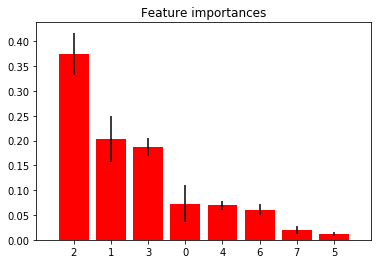

In [38]:
plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train.shape[1]), importances[indices],
       color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [39]:
X_train.columns

Index(['Name', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Type', 'Breed2',
       'Color', 'numCol'],
      dtype='object')

* Breed2와 numCol은 importance가 낮아서 제외하고 다시 시도

In [40]:
def grbc(train, test, train_y, test_y):
    param = [{'n_estimators': [100, 300, 500],
         'learning_rate': [0.1, 0.05, 0.01]}]
    name = 'Gradient boosting'
    model = GridSearchCV(GradientBoostingClassifier(), param, cv=3)
    return model_cv(train, test, train_y, test_y, model, name)
    
def xgbc(train, test, train_y, test_y):
    param = [{'n_estimators': [100, 500, 1000],
         'learning_rate': [0.1, 0.05, 0.01],}]
    model = GridSearchCV(XGBClassifier(), param, cv=3)
    name = 'XGBoost'
    return model_cv(train, test, train_y, test_y, model, name)

def lgbm(train, test, train_y, test_y):
    param = [{'n_estimators': [100, 500, 1000],
         'learning_rate': [0.1, 0.05, 0.01]}]
    model = GridSearchCV(LGBMClassifier(), param, cv=3)
    name = 'LightGBM'
    return model_cv(train, test, train_y, test_y, model, name)

In [42]:
X = df[['Name', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Type', 'Color']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [43]:
forest(X_train, X_test, y_train, y_test)
lgbm(X_train, X_test, y_train, y_test)
xgbc(X_train, X_test, y_train, y_test)
grbc(X_train, X_test, y_train, y_test)

Random forest :  {'criterion': 'gini', 'n_estimators': 500}
train score: 0.7541155342711763
test score: 0.6283106389346103
log loss: 1.6045357783864755

LightGBM :  {'learning_rate': 0.01, 'n_estimators': 1000}
train score: 0.672353586750474
test score: 0.6588358521622026
log loss: 0.8346080254590055

XGBoost :  {'learning_rate': 0.1, 'n_estimators': 500}
train score: 0.6656190761249127
test score: 0.6527008828370492
log loss: 0.835456480838252

Gradient boosting :  {'learning_rate': 0.05, 'n_estimators': 300}
train score: 0.6607303202633942
test score: 0.6509052820589556
log loss: 0.8354956467453897



In [46]:
X = df[['Name', 'SexuponOutcome', 'AgeuponOutcome', 'Breed']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [47]:
forest(X_train, X_test, y_train, y_test)
lgbm(X_train, X_test, y_train, y_test)
xgbc(X_train, X_test, y_train, y_test)
grbc(X_train, X_test, y_train, y_test)

Random forest :  {'criterion': 'gini', 'n_estimators': 500}
train score: 0.7181482590042901
test score: 0.6302558731108784
log loss: 1.6238915073271998

LightGBM :  {'learning_rate': 0.01, 'n_estimators': 500}
train score: 0.6588845654993515
test score: 0.6540475834206195
log loss: 0.8453237635854528

XGBoost :  {'learning_rate': 0.1, 'n_estimators': 500}
train score: 0.6645714855831587
test score: 0.6549453838096663
log loss: 0.8353536021444887

Gradient boosting :  {'learning_rate': 0.05, 'n_estimators': 500}
train score: 0.6657188466526988
test score: 0.6537483166242706
log loss: 0.8386787975551311



In [48]:
lgbm = LGBMClassifier(learning_rate=0.01, n_estimators=1000)
xgbc = XGBClassifier(learning_rate=0.1, n_estimators=500)

In [49]:
lgbm.fit(X_train, y_train)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Submit

In [72]:
test = pd.read_csv('data/test.csv')

In [73]:
def Naming(x):
    if type(x) == float:
        return 'Unnamed'
    else:
        return 'Named'
test['Name'] = test['Name'].transform(Naming)

In [74]:
def intact(x):
    if 'Neutered' in x or 'Spayed' in x:
        return 'Neutered'
    elif 'Male' in x:
        return 'Male'
    elif 'Female' in x:
        return 'Female'
    else:
        return 'Unknown'
test['SexuponOutcome'] = test['SexuponOutcome'].fillna('Unknown')
test['SexuponOutcome'] = test['SexuponOutcome'].apply(intact)

In [75]:
def Agebyday(x):
    num, unit = x.split(' ')
    if unit == 'year' or unit == 'years':
        x = int(num) * 365
    elif unit == 'month' or unit == 'months':
        x = int(num) * 30
    elif unit == 'week' or unit == 'weeks':
        x = int(num) * 7
    elif unit == 'day' or unit == 'days':
        x = int(num)
    return x
test['AgeuponOutcome'] = test['AgeuponOutcome'].fillna('0 day')
test['AgeuponOutcome'] = test['AgeuponOutcome'].apply(Agebyday)

In [76]:
def breed_optimal(x):
    if '/' in x:
        x = x[0:x.index('/')]
        return x
    elif ' Mix' in x:
        x = x[0:-4]
        return x
    else:
        return x
test['Breed'] = test['Breed'].apply(breed_optimal)

In [77]:
test['Breed'] = test['Breed'].replace('Pit Bull', 'Bull Terrier')
test['Breed'] = test['Breed'].replace('German Shepherd', 'German Shepherd Dog')
test['Breed'] = test['Breed'].replace('Anatol Shepherd', 'Anatolian Shepherd Dog')
test['Breed'] = test['Breed'].replace('Catahoula', 'Catahoula Cur')
test['Breed'] = test['Breed'].replace('Staffordshire', 'American Staffordshire Terrier')
test['Breed'] = test['Breed'].replace('Doberman Pinsch', 'Doberman Pinscher')
test['Breed'] = test['Breed'].replace('Queensland Heeler', 'Australian Cattle Dog')
test['Breed'] = test['Breed'].replace('Flat Coat Retriever', 'Flat-Coated Retriever')
test['Breed'] = test['Breed'].replace('Chinese Sharpei', 'Chinese Shar Pei')
test['Breed'] = test['Breed'].replace('Rhod Ridgeback', 'Rhodesian Ridgeback')
test['Breed'] = test['Breed'].replace('Soft Coated Wheaten Terrier', 'Soft-Coated Wheaten Terrier')
test['Breed'] = test['Breed'].replace('Bruss Griffon', 'Brussels Griffon')
test['Breed'] = test['Breed'].replace('Redbone Hound', 'Redbone Coonhound')
test['Breed'] = test['Breed'].replace('West Highland', 'West Highland White Terrier')
test['Breed'] = test['Breed'].replace('Wire Hair Fox Terrier', 'Wire Fox Terrier')
test['Breed'] = test['Breed'].replace('Dogo Argentino', 'Mastiff')
test['Breed'] = test['Breed'].replace('Alaskan Husky', 'Alaskan Malamute')
test['Breed'] = test['Breed'].replace('Pbgv', 'Petit Basset Griffon Vendeen')
test['Breed'] = test['Breed'].replace('Chesa Bay Retr', 'Chesapeake Bay Retriever')
test['Breed'] = test['Breed'].replace('Cavalier Span', 'Cavalier King Charles Spaniel')
test['Breed'] = test['Breed'].replace('Dutch Shepherd', 'Dutch Shepherd Dog')
test['Breed'] = test['Breed'].replace('English Coonhound', 'American English Coonhound')
test['Breed'] = test['Breed'].replace('American Eskimo', 'American Eskimo Dog')
test['Breed'] = test['Breed'].replace('Bluetick Hound', 'Bluetick Coonhound')
test['Breed'] = test['Breed'].replace('Patterdale Terr', 'Patterdale Terrier')
test['Breed'] = test['Breed'].replace('Chinese Crested', 'Chinese Crested Dog')
test['Breed'] = test['Breed'].replace('Podengo Pequeno', 'Portuguese Podengo Pequeno')
test['Breed'] = test['Breed'].replace('Dogue De Bordeaux', 'Dogue de Bordeaux')
test['Breed'] = test['Breed'].replace('Boykin Span', 'Boykin Spaniel')
test['Breed'] = test['Breed'].replace('Landseer', 'Newfoundland')
test['Breed'] = test['Breed'].replace('Schnauzer Giant', 'Giant Schnauzer')
test['Breed'] = test['Breed'].replace('Glen Of Imaal', 'Glen of Imaal Terrier')
test['Breed'] = test['Breed'].replace('Treeing Cur', 'Treeing Walker Coonhound')
test['Breed'] = test['Breed'].replace('Bedlington Terr', 'Bedlington Terrier')
test['Breed'] = test['Breed'].replace('Picardy Sheepdog', 'Berger Picard')
test['Breed'] = test['Breed'].replace('Presa Canario', 'Mastiff')
test['Breed'] = test['Breed'].replace('Nova Scotia Duck Tolling Retriever', 'Nova Scotia Duck-Tolling Retriever')
test['Breed'] = test['Breed'].replace('Port Water Dog', 'Portuguese Water Dog')
test['Breed'] = test['Breed'].replace('Mexican Hairless', 'American Hairless Terrier')
test['Breed'] = test['Breed'].replace('Treeing Tennesse Brindle', 'Treeing Walker Coonhound')
test['Breed'] = test['Breed'].replace('Entlebucher', 'Entlebucher Mountain Dog')
test['Breed'] = test['Breed'].replace('Sealyham Terr', 'Sealyham Terrier')
test['Breed'] = test['Breed'].replace('Black', 'Black and Tan Coonhound')
test['Breed'] = test['Breed'].replace('Unknown', 'Chihuahua Shorthair')

In [78]:
Breed = pd.read_csv('data/breed.csv')
test = test.join(Breed.set_index('Breed'), on='Breed')
test['Type'] = test['Type'].fillna('Cat')

In [79]:
test['Name'] = encoder.fit_transform(test['Name'])
test['SexuponOutcome'] = encoder.fit_transform(test['SexuponOutcome'])
test['Breed'] = encoder.fit_transform(test['Breed'])
test['Type'] = encoder.fit_transform(test['Type'])

In [80]:
test_X = test[['Name' ,'SexuponOutcome', 'AgeuponOutcome', 'Breed']]

In [81]:
pred_lgbm = lgbm.predict_proba(test_X)
pred_xgbc = xgbc.predict_proba(test_X)
submit_lgbm = pd.DataFrame(pred_lgbm, columns=lgbm.classes_)
submit_xgbc = pd.DataFrame(pred_xgbc, columns=xgbc.classes_)
id_index =  pd.DataFrame([{"ID": (i+1)} for i, _ in enumerate(pred_lgbm)])

In [82]:
submit_lgbm = pd.concat([id_index, submit_lgbm], axis=1)
submit_xgbc = pd.concat([id_index, submit_xgbc], axis=1)

In [83]:
submit_lgbm.to_csv('data/submit_lgbm.csv', index=False)
submit_xgbc.to_csv('data/submit_xgbc.csv', index=False)

# Result
* LightGBM 제출 결과, log loss 0.86108으로 838등에 해당하는 점수를 얻었음.